In [102]:
import os
import time
from datetime import date
from pathlib import Path
from typing import Optional

import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import clear_output, display

import matplotlib.pyplot as plt

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.webdriver.chrome.options import Options as ChromeOptions
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import WebDriverException

In [ ]:
DATA_DIR = Path("D:/Automation/Inventory Value")
DATA_DIR.mkdir(parents=True, exist_ok=True)
CSV_PATH = DATA_DIR / "cases_prices.csv"
SAVE_TO_CSV = True

live_plot: Optional[go.FigureWidget] = None

CHROMEDRIVER_PATH = os.getenv("CHROMEDRIVER_PATH", r"D:\Programs\Chrome\chromedriver-win64\chromedriver.exe")
CHROME_BINARY_PATH = os.getenv("CHROME_BINARY_PATH", r"D:\Programs\Chrome\chrome-win64\chrome.exe")

ITEMS = [
    ("https://steamcommunity.com/market/listings/730/Dreams%20%26%20Nightmares%20Case", "Dreams & Nightmares Case", 1),
    ("https://steamcommunity.com/market/listings/730/Revolution%20Case", "Revolution Case", 2),
    ("https://steamcommunity.com/market/listings/730/Kilowatt%20Case", "Kilowatt Case", 3),
    ("https://steamcommunity.com/market/listings/730/Fracture%20Case", "Fracture Case", 1),
    ("https://steamcommunity.com/market/listings/730/Recoil%20Case", "Recoil Case", 2),
    ("https://steamcommunity.com/market/listings/730/Gallery%20Case", "Gallery Case", 3),
]

In [104]:
def create_driver(headless: bool = True) -> webdriver.Chrome:
    """Create and return a configured Chrome WebDriver instance."""
    chrome_options = ChromeOptions()
    if CHROME_BINARY_PATH:
        chrome_options.binary_location = CHROME_BINARY_PATH
    chrome_options.add_argument("--log-level=3")
    chrome_options.add_experimental_option("excludeSwitches", ["enable-logging"])
    if headless:
        chrome_options.add_argument("--headless=new")

    try:
        service = ChromeService(executable_path=CHROMEDRIVER_PATH)
        driver = webdriver.Chrome(service=service, options=chrome_options)
        print("[/] Using Chrome WebDriver")
        return driver
    except WebDriverException as e:
        print(f"[X] Failed to initialize WebDriver: {e}")
        raise

In [105]:
def scrape_price(driver: webdriver.Chrome, url: str) -> Optional[float]:
    """Scrape the current Steam market price from a listing page."""
    try:
        driver.get(url)
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located(
                (By.CLASS_NAME, "market_commodity_orders_header_promote")
            )
        )
        spans = driver.find_elements(By.CLASS_NAME, "market_commodity_orders_header_promote")
        if spans:
            price_text = spans[-1].text.strip().replace("$", "")
            return float(price_text)
        print(f"[!] No price found on {url}")
        return None
    except Exception as e:
        print(f"[!] Error scraping {url}: {e}")
        return None

In [106]:
def create_live_plot() -> go.FigureWidget:
    """Create & display the initial empty FigureWidget with table + pie."""
    global live_plot
    if live_plot is not None: # type: ignore
        return live_plot      # type: ignore

    fig = go.FigureWidget(make_subplots(
        rows=2, cols=2,
        specs=[
            [{"type": "table", "colspan": 2}, None],
            [{"type": "domain"}, {"type": "domain"}]
        ],
        subplot_titles=["Steam Market Item Prices", ""],
        row_heights=[0.6, 0.4],
        vertical_spacing=0.1
    ))

    fig.add_trace(go.Table(
        columnwidth=[180, 80, 80, 120, 120],
        header=dict(values=["Item", "Price", "Quantity", "Price after fee", "Total after fee"]),
        cells=dict(values=[[], [], [], [], []])
    ), row=1, col=1)

    fig.add_trace(go.Pie(
        labels=[], values=[], textinfo='percent+label', hoverinfo="label+value",
        marker=dict(line=dict(color='black', width=2)),
        showlegend=True
    ), row=2, col=1)

    fig.update_layout(
        height=850,
        title_text="Steam Market Data Summary",
        legend=dict(
            x=1.05,
            y=0.35,
            xanchor="left",
            font=dict(size=10)
        ),
        margin=dict(t=60, b=60),
        autosize=True,
    )

    live_plot = fig
    display(live_plot)
    return live_plot


In [107]:
def update_plot(df: pd.DataFrame) -> None:
    """Display a live Plotly pie chart of total values."""
    global live_plot
    if live_plot is None or df.empty: # type: ignore
        return
    clear_output(wait=True)
    if df.empty:
        print("[!] Waiting for data...")
        return

    df_sorted = df.sort_values(by="total_after_fee", ascending=False)
    total_value = df_sorted["total_after_fee"].sum()
    
    live_plot.data[0].cells.values = [ # type: ignore
        df_sorted["item"],
        df_sorted["price"].map(lambda x: f"{x:.2f}"),
        df_sorted["quantity"].astype(str),
        df_sorted["price_after_fee"].map(lambda x: f"{x:.2f}"),
        df_sorted["total_after_fee"].map(lambda x: f"{x:.2f}")
    ]
    
    live_plot.data[1].labels = df_sorted["item"] # type: ignore
    live_plot.data[1].values = df_sorted["total_after_fee"] # type: ignore
    
    live_plot.layout.title.text = f"Steam Market Data Summary — Total ${total_value:.2f}" # type: ignore
    display(live_plot) # type: ignore

In [108]:
def get_prices(output_csv: Path) -> pd.DataFrame:
    """Scrape all items one-by-one, updating the CSV and plot live."""
    df = pd.DataFrame(columns=["item", "price", "quantity", "price_after_fee", "total_after_fee", "date"])
    driver = create_driver(headless=False)
    try:
        for url, name, qty in ITEMS:
            print(f"[*] Scraping {name} ...", end=" ")
            price = scrape_price(driver, url)
            if price:
                new_row = {
                    "item": name,
                    "price": price,
                    "quantity": qty,
                    "price_after_fee": price * 0.88,
                    "total_after_fee": price * qty * 0.88,
                    "date": pd.Timestamp.now().normalize()
                }
                df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
                print(f"[/] ${price:.2f}")
                
                if SAVE_TO_CSV:
                    df.to_csv(output_csv, index=False)

                if live_plot is None:
                    create_live_plot()
                update_plot(df)
                time.sleep(0.5)
            else:
                print("[X] Failed")

        print(f"\n[/] Completed scraping {len(df)} items.")
        if SAVE_TO_CSV:
            print(f"[/] Final CSV saved to {output_csv}")

    finally:
        driver.quit()

    return df

In [109]:
def plot_skin_contributions(df: pd.DataFrame, output_dir: Path) -> None:
    """Create and save a pie chart of total values."""
    if df.empty:
        print("[!] No data to plot.")
        return

    df_sorted = df.sort_values(by="total_after_fee", ascending=False)
    names = df_sorted["item"]
    totals = df_sorted["total_after_fee"]
    grand_total = totals.sum()

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(aspect="equal"))
    wedges, texts, autotexts = ax.pie( # type: ignore
        totals,
        labels=names, # type: ignore
        autopct=lambda pct: f"{pct:.1f}%",
        startangle=0,
        wedgeprops=dict(width=0.3)
    )
    plt.title("Skin Contribution to Grand Total")
    plt.text(0, -1.25, f"Grand Total: {grand_total:.2f}$", ha="center", fontsize=12)
    plt.legend(wedges, names, title="Skins", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

    current_time = date.today()
    output_path = output_dir / f"skin_contribution_{current_time.month}-{current_time.day}.png"
    plt.savefig(output_path, bbox_inches="tight")
    print(f"[/] Graph saved to {output_path}")

FigureWidget({
    'data': [{'cells': {'values': [['Gallery Case', 'Dreams & Nightmares Case',
                                   'Kilowatt Case', 'Revolution Case', 'Recoil
                                   Case', 'Fracture Case'], ['1.43', '1.90',
                                   '0.49', '0.57', '0.42', '0.75'], ['3', '1', '3',
                                   '2', '2', '1'], ['1.26', '1.67', '0.43', '0.50',
                                   '0.37', '0.66'], ['3.78', '1.67', '1.29',
                                   '1.00', '0.74', '0.66']]},
              'columnwidth': [180, 80, 80, 120, 120],
              'domain': {'x': [0.0, 1.0], 'y': [0.4600000000000001, 1.0]},
              'header': {'values': ['Item', 'Price', 'Quantity', 'Price after fee', 'Total after fee']},
              'type': 'table',
              'uid': 'a6558951-e10c-49b4-ad09-027f7565db26'},
             {'domain': {'x': [0.0, 0.45], 'y': [0.0, 0.36000000000000004]},
              'hoverinfo': 'label+valu


[/] Completed scraping 6 items.
[/] Final CSV saved to D:\Automation\Inventory Value\cases_prices.csv
[/] Graph saved to D:\Automation\Inventory Value\skin_contribution_10-6.png
[/] All tasks completed successfully.


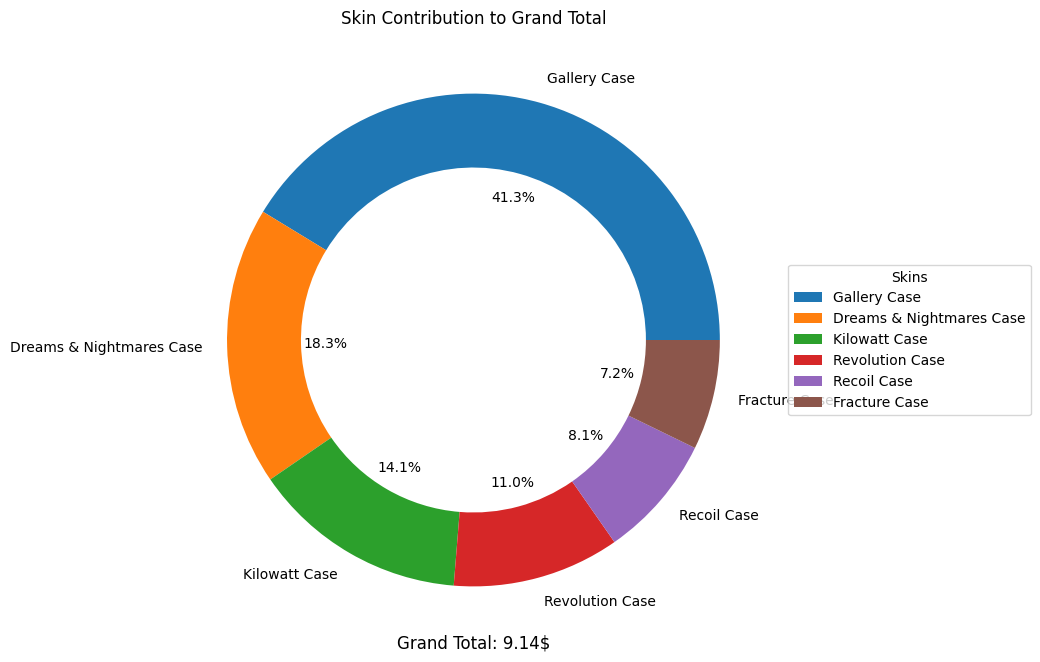

In [110]:
def main() -> None:
    """Run the scraping and plotting workflow."""
    df = get_prices(CSV_PATH)
    plot_skin_contributions(df, DATA_DIR)
    print("[/] All tasks completed successfully.")


if __name__ == "__main__":
    main()